<a href="https://colab.research.google.com/github/Rodolfo9706/UAV-clasificator/blob/main/UAVS_clasificator_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip -q vehiculos2.zip
!ls

sample_data  vehiculos2  vehiculos2.zip


In [ ]:
ls vehiculos2

avion/  multorotor/


In [ ]:
import os

num_skipped = 0
for folder_name in ("avion", "multorotor"):
    folder_path = os.path.join("vehiculos2", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Eliminar imagenes corruptas
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 135 images


In [ ]:

"""
La gran cantidad de datos y la complejidad de los modelos requieren tiempos de entrenamiento muy largos.
Como tal, normalmente se utiliza una simple separación de datos en conjuntos de datos de entrenamiento y prueba o conjuntos de datos de entrenamiento y validación.
En esta sección tambien se estandarizó el tamaño de las imagenes 180 x 180, y se agregó en tamaño de batch de validación y entrenamiento.
"""

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "vehiculos2",
    validation_split=0.2,
    #class_mode="binary",
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "vehiculos2",
    validation_split=0.2,
    subset="validation",
    #class_mode="binary",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1661 files belonging to 2 classes.
Using 1329 files for training.
Found 1661 files belonging to 2 classes.
Using 332 files for validation.


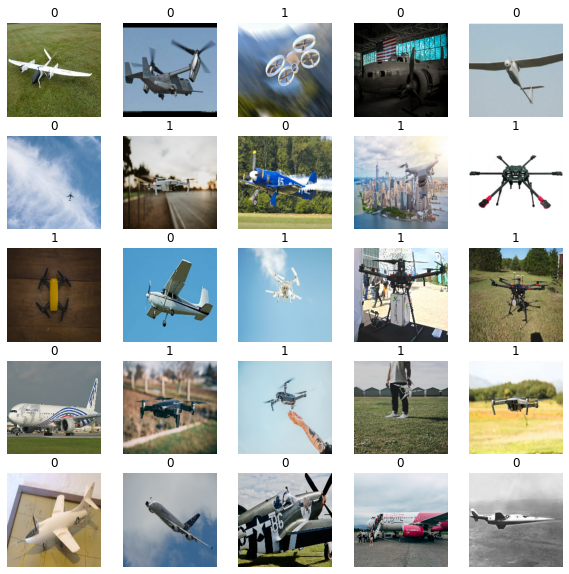

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

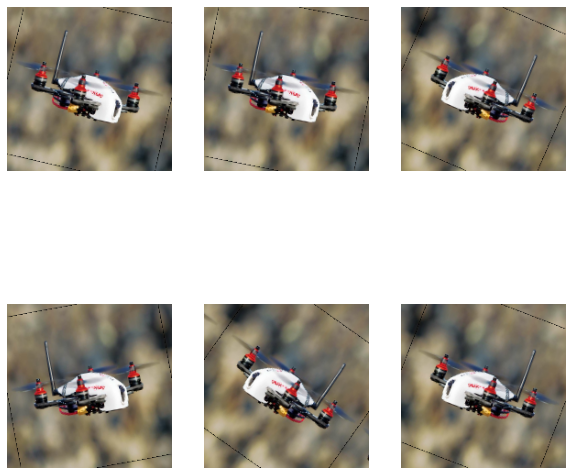

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:

"""
Se uso una red neuronal residual (RESNET) basada en convoluciones , esta red permite agregar multicapas sin verse afectado por el desvanecimiento de gradiente.
La red esta integrada por bloques, cada bloque cuenta con las capas,convoluciones, activación, Normalización del batch. 
cuando se reducen las capas unicamente los pesos entrenados son congelados en esa capa de tal forma que solamente se entrenan las capas que no tienen pesos congelados.
Capas de entrada El bloque de entrada cuenta con 2 capas convolucionales, una con 16 neuronas y la otra con 32, su función de activación es una relu, la cual es ideal para modelos convolucionales. 
Tambien cuenta con una capa para normalizar el batch de entrenamiento y validación.
Capas ocultas Posteriormente se tienen otro 4 bloques con la misma cantidad de capas, pero difiriendo en la cantidad de neuronas que contiene la capa convolucional [64, 128, 256, 364].
Capa de salida En la capa de salida, se uso una función de activación de tipo sigmoide. ideales para las capas de salida debido a que tiene limites de 0,1 y son continuas.
"""

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
   # aumentar el tamaño de la base de datos con las imaganes transformadas
    x = data_augmentation(inputs)

    #  # bloque de entrada
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [64, 128, 256, 364]: #[128, 256, 512, 728]: #[64, 128, 256, 364]
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        #Residuos
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Apartar el siguiente residuo
        previous_block_activation = x  # residuos anteriores


    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

# capa de salidas
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.9)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
"""
Etapa de backporpagation: por el metodo de gradiente descendiente se buscar que el error se aproxime 
a cero, en keras los optimizadores se encargan de esta función.
En esencia, el objetivo del entrenamiento de redes neuronales es minimizar la función de coste 
encontrando los pesos adecuados para las aristas de la red .
El descubrimiento de estos pesos se lleva a cabo mediante una algoritmo numérico llamado backpropagation.
"""

epochs = 90

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    #loss="categorical_crossentropy",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit_generator(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
21/21 [==============================] - 9s 422ms/step - loss: 0.9521 - accuracy: 0.5297 - val_loss: 0.6926 - val_accuracy: 0.5241
Epoch 2/100
21/21 [==============================] - 11s 520ms/step - loss: 0.8931 - accuracy: 0.5786 - val_loss: 0.6922 - val_accuracy: 0.5241
Epoch 3/100
21/21 [==============================] - 11s 519ms/step - loss: 0.8784 - accuracy: 0.5636 - val_loss: 0.6920 - val_accuracy: 0.5241
Epoch 4/100
21/21 [==============================] - 11s 517ms/step - loss: 0.8641 - accuracy: 0.5877 - val_loss: 0.6919 - val_accuracy: 0.5241
Epoch 5/100
21/21 [==============================] - 11s 530ms/step - loss: 0.8716 - accuracy: 0.5681 - val_loss: 0.6918 - val_accuracy: 0.5241
Epoch 6/100
21/21 [==============================] - 11s 529ms/step - loss: 0.8102 - accuracy: 0.6087 - val_loss: 0.6919 - val_accuracy: 0.5241
Epoch 7/100
21/21 [==============================] - 11s 529m

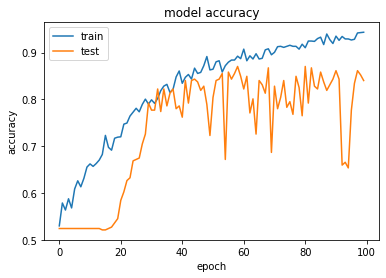

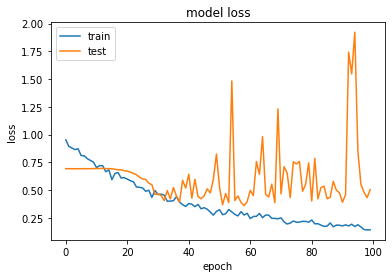

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "vehiculos2/multorotor/m25.jpg", target_size=image_size  #"vehiculos1/avion/a603.jpg"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent avion and %.2f percent multirotor."
    % (100 * (1 - score), 100 * score)
)

This image is 18.04 percent avion and 81.96 percent multirotor.
